In [1]:
!pip install pandas fiona shapely pyproj rtree 
!pip install contextily
!pip install geopandas
!pip install topojson
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.2/17.2 MB 42.8 MB/s  0:00:00m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [fiona]32m3/4 [fiona]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 33.6 MB/s  0:00:00m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7/7 [contextily]7 [geopy]io]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]1/2 [openpyxl]


In [5]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import pandas as pd
import openpyxl

In [6]:
#### On importe le fichier répertoriant les catastrophes naturelles de type inondations reconnues pour chaque commune

import requests

# Téléchargement du fichier avec le nombre de catastrophes reconnues pour chaque commune, directement depuis le site Géorisques
url_inondations = "https://files.georisques.fr/onrn/2025/ONRN_Reco_INON_8224.xlsx"
response_inondations = requests.get(url_inondations)

# Enregistrement du fichier localement
with open("ONRN_Reco_INON_8224.xlsx", "wb") as f:
    f.write(response_inondations.content)

# Importation et ouverture avec Pandas
inondations = pd.read_excel("ONRN_Reco_INON_8224.xlsx", sheet_name="Nb reco. Cat Nat")
inondations.head()

,Code INSEE,Commune,"Nombre de reconnaissances Cat Nat\n inondation (tous types)\n(Somme : coulée de boue, remontée de nappe, submersion marine)"
0,01001,L'Abergement-Clémenciat,2
1,01002,L'Abergement-de-Varey,2
2,01004,Ambérieu-en-Bugey,4
3,01005,Ambérieux-en-Dombes,2
4,01006,Ambléon,1


In [7]:
#### Et on importe le fichier avec les shapefiles des communes

# Téléchargement du fichier avec les shapefiles des communes, directement depuis Datagouv
url_communes = "https://www.data.gouv.fr/api/1/datasets/r/0e117c06-248f-45e5-8945-0e79d9136165"
zip_communes = "shapefiles.zip"

# Enregistrement du fichier localement
response_communes = requests.get(url_communes)
with open(zip_communes, "wb") as f:
    f.write(response_communes.content)

# Importation avec GeoPandas
communes = gpd.read_file(f"zip://{zip_communes}!communes-20220101.shp")
communes.head()

,insee,nom,wikipedia,surf_ha,geometry
0,2B222,Pie-d'Orezza,fr:Pie-d'Orezza,573.0,"POLYGON ((9.32017 42.38507, 9.32028 42.3851, 9..."
1,2B137,Lano,fr:Lano,824.0,"POLYGON ((9.2001 42.39013, 9.20014 42.39014, 9..."
2,2B051,Cambia,fr:Cambia,833.0,"POLYGON ((9.27757 42.37509, 9.27758 42.37512, ..."
3,2B106,Érone,fr:Érone,393.0,"POLYGON ((9.2512 42.37605, 9.25132 42.37603, 9..."
4,2B185,Oletta,fr:Oletta,2674.0,"POLYGON ((9.2834 42.66273, 9.28345 42.66273, 9..."


In [ ]:
### Préparation du dataframe de travail

# On renomme la colonne avec le code INSEE dans le df des communes (shapefiles) pour le joindre à celui tiré de Géorisques
communes = communes.rename(columns={"insee" : "Code INSEE"})
communes.head()

# On fait la jointure
df = pd.merge(communes, inondations, on="Code INSEE")

# On supprime la colonne wikipedia (inutile) et nom (identique à la colonne 'Commune')
del df['wikipedia']
del df['nom']
df.head()

# On réorganise le df (ordre des colonnes)
df = df.iloc[:,[3,0,1,2,4]]

# On renomme la dernière colonne (pour pouvoir l'appeler facilement)
df.columns = ['Commune', 'Code INSEE', 'surf_ha', 'geometry', 'Occurrences'] 

# On remplace "Pas de reconnaissance" par 0 (on transforme la ligne en numérique : les erreurs (ie les caractères) sont alors convertis en 0)
df["Occurrences"] = pd.to_numeric(df["Occurrences"], errors="coerce").fillna(0)

In [9]:
### Statistiques descriptives (pour vérifier que tout fonctionne)

# Moyenne
df['Occurrences'].mean()

# Variance
df['Occurrences'].var()

np.float64(7.790261657471829)

In [10]:
# Conversion du fichier au format GeoPandas
gdf = gpd.GeoDataFrame(df, geometry='geometry')

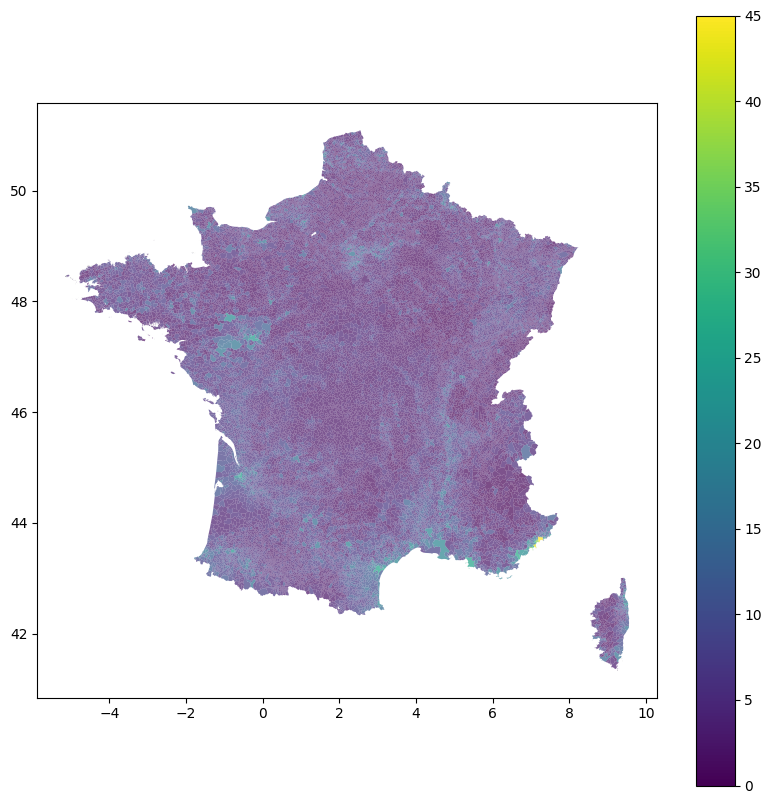

In [11]:
### Cartographie

# Utilisation de l'epsg=4326
gdf.set_crs(epsg=4326, inplace=True)

# Premier plot (villes coloriées selon l'occurrence des inondations)
ax = gdf.plot(
    column='Occurrences',      # on utilise la colonne 'Occurrences' pour colorer différemment les villes
    cmap='viridis',            # code pour colorier
    legend=True,               # on affiche la légende (couleurs sur la droite)
    markersize=50,             # taille des points (à revoir éventuellement)
    figsize=(10, 10),          # taille de la figure (idem)
    alpha=0.7                  # transparence
)
plt.show()

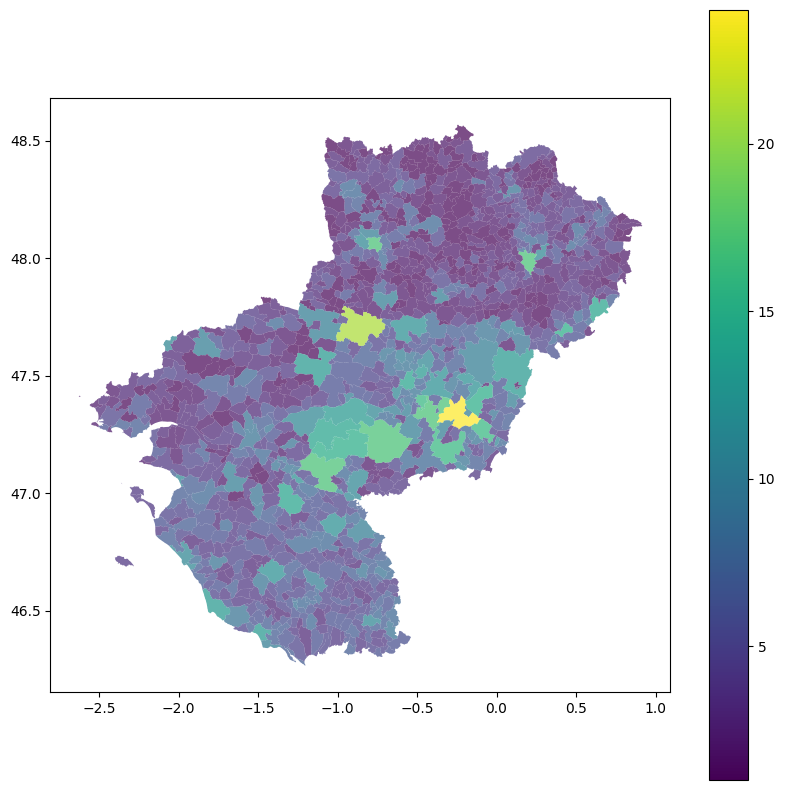

In [ ]:
#### On observe beaucoup d'inondations dans les Pays de la Loire : on essaye de les cartographier pour voir plus finement les différences

# On crée une variable département dans notre df 
gdf['Département'] = gdf['Code INSEE'].str.slice(0,2)

# On crée le géo-dataframe avec seulement les Pays de la Loire
gdf_pdl = gdf.copy()
gdf_pdl = gdf_pdl[gdf_pdl['Département'].isin(["44","49","53","72","85"])]

# On utilise le même fond de carte (valable pour toute la France hexagonale)
gdf_pdl.set_crs(epsg=4326, inplace=True)

# Premier plot (villes coloriées selon l'occurrence des inondations)
ax_pdl = gdf_pdl.plot(
    column='Occurrences',      # on utilise la colonne 'Occurrences' pour colorer différemment les villes
    cmap='viridis',            # code pour colorier
    legend=True,               # on affiche la légende (couleurs sur la droite)
    markersize=50,             # taille des points (à revoir éventuellement)
    figsize=(10, 10),          # taille de la figure (idem)
    alpha=0.7                  # transparence
)
plt.show()

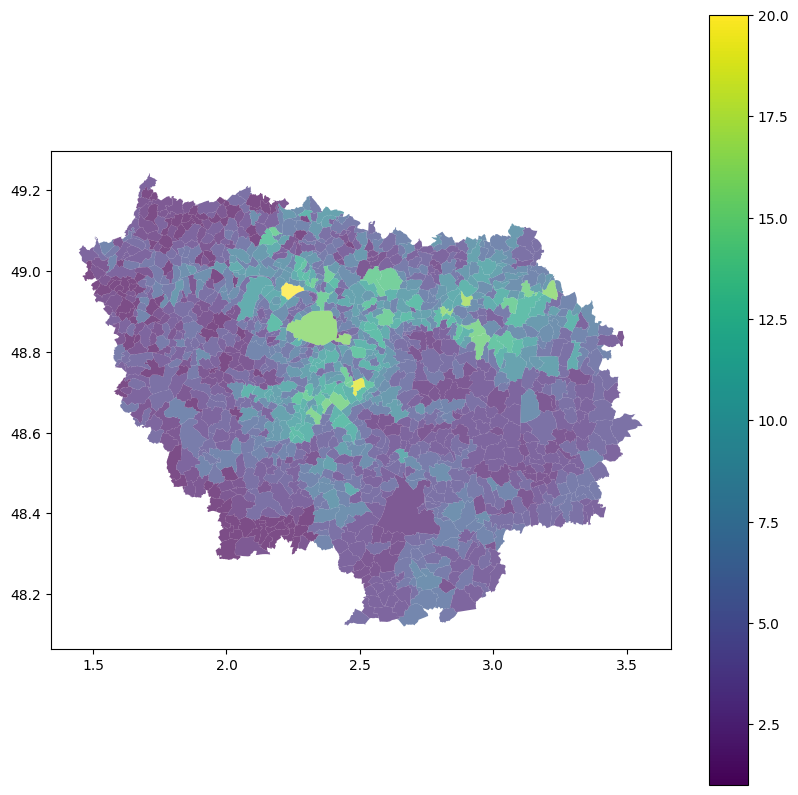

In [13]:
#### On veut voir en IDF

# On crée une variable département dans notre df 
gdf['Département'] = gdf['Code INSEE'].str.slice(0,2)

# On crée le géo-dataframe avec seulement les Pays de la Loire
gdf_idf = gdf.copy()
gdf_idf = gdf_idf[gdf_idf['Département'].isin(["75","77","78","91","92", "93", "94", "95"])]

# On utilise le même fond de carte (valable pour toute la France hexagonale)
gdf_idf.set_crs(epsg=4326, inplace=True)

# Premier plot (villes coloriées selon l'occurrence des inondations)
ax_pdl = gdf_idf.plot(
    column='Occurrences',      # on utilise la colonne 'Occurrences' pour colorer différemment les villes
    cmap='viridis',            # code pour colorier
    legend=True,               # on affiche la légende (couleurs sur la droite)
    markersize=50,             # taille des points (à revoir éventuellement)
    figsize=(10, 10),          # taille de la figure (idem)
    alpha=0.7                  # transparence
)
plt.show()

In [ ]:
#### On importe le dossier complet de l'INSEE pour apparier avec des données "sociales"

# On télécharge le dossier qui contient notre csv
url_complet = "https://www.insee.fr/fr/statistiques/fichier/5359146/dossier_complet.zip"
zip_path = "dossier_complet.zip" 

# On enregistre le fichier localement
response = requests.get(url_complet)
with open(zip_path, "wb") as f:
    f.write(response.content)

# On importe notre fichier avec Pandas (et on l'appelle complet_insee)
csv_complet_insee = "dossier_complet.csv" 
with zipfile.ZipFile(zip_path) as z:
    with z.open(csv_complet_insee) as f:
        complet_insee = pd.read_csv(f, sep=';', encoding='utf-8')

In [86]:
#### On fait à nouveau la jointure avec notre df précédent

# On renomme la variable CODGEO en "Code INSEE" pour que ce soit homogène
complet_insee = complet_insee.rename(columns={"CODGEO":"Code INSEE"})

# On s'assure que la variable "Code INSEE" est similaire dans les deux tableaux
gdf['Code INSEE'] = gdf['Code INSEE'].astype(str).str.zfill(5)                     # zfill remplit de zéros à gauche pour atteindre 5 signes (pour harmoniser à la norme INSEE)
complet_insee['Code INSEE'] = complet_insee['Code INSEE'].astype(str).str.zfill(5)

# On fusionne
gdf_complet = pd.merge(gdf, complet_insee, on="Code INSEE") # on obtient un tableau à 1980 colonnes (et toujours 34 802 lignes)

In [104]:
#### Notre super gdf contient 1980 colonnes : on prend la pauvreté pour la visualiser

# On ne retient que les variables d'intérêt
gdf_pauvrete = gdf_complet.copy()
gdf_pauvrete = gdf_pauvrete[['Commune', 'Code INSEE', 'surf_ha', 'geometry', 'Occurrences', 'TP6021']]

In [ ]:
#### Problème : c'est illisible. Solution : on retourne dans les Pays de la Loire !

# On filtre, dans gdf_complet, les départements des Pays de la Loire (comme plus haut)
gdf_pauvrete['Département'] = gdf_pauvrete['Code INSEE'].str.slice(0,2)
gdf_pauvrete_pdl = gdf_pauvrete.copy()
gdf_pauvrete_pdl = gdf_pauvrete_pdl[gdf_pauvrete_pdl['Département'].isin(["44","49","53","72","85"])]

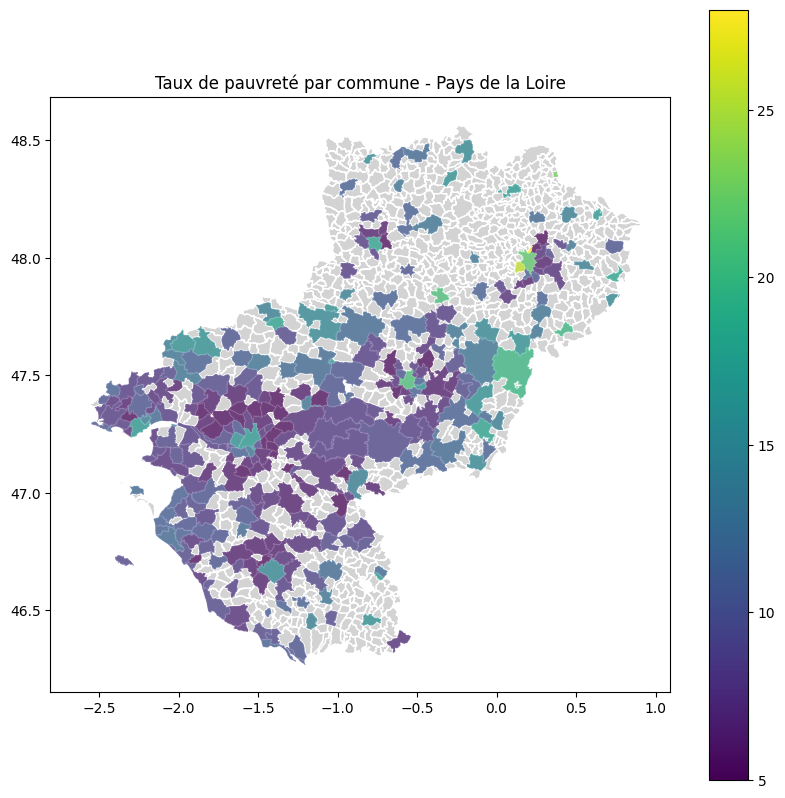

In [108]:
#### On visualise

import re

# Nettoyage de la colonne TP6021 (reprendre éventuellement)
def clean_numeric(val):
    if val is None:
        return None
    val = str(val)
    val = re.sub(r'[^0-9\.,-]', '', val)  # garder chiffres, . et ,
    val = val.replace(',', '.')            # convertir virgule en point
    try:
        return float(val)
    except:
        return None

# On applique la fonction à la colonne
gdf_pauvrete['TP6021'] = gdf_pauvrete['TP6021'].apply(clean_numeric)

# Toujours le même epsg
gdf_pauvrete_pdl.set_crs(epsg=4326, inplace=True)

# On représente d'abord toutes les communes sur fond gris
gdf_pauvrete_pdl.plot(
    color='lightgrey', 
    edgecolor='white',
    figsize=(10,10)
)

# Puis les points avec les données
gdf_pauvrete_pdl.dropna(subset=['TP6021']).plot(
    column='TP6021',
    cmap='viridis',
    legend=True,
    markersize=50,
    alpha=0.7,
    ax=plt.gca()
)

plt.title("Taux de pauvreté par commune - Pays de la Loire")
plt.show()

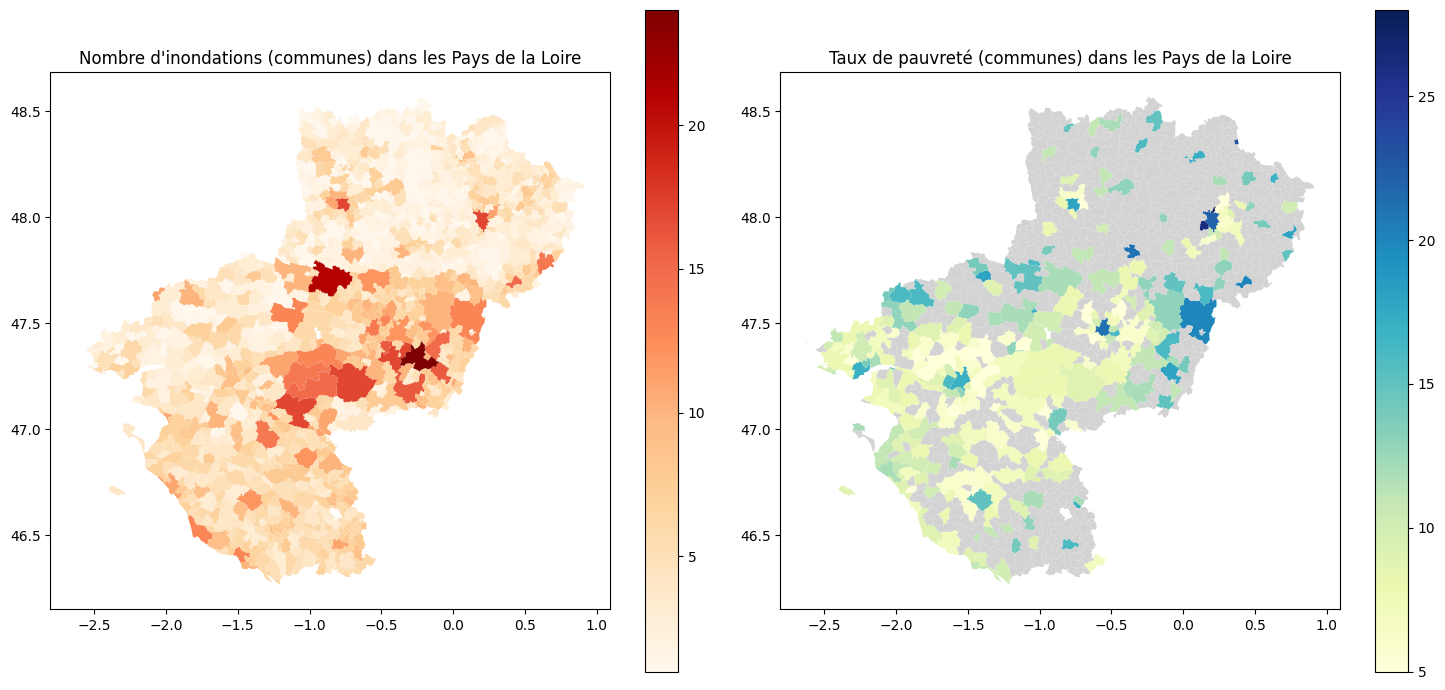

In [116]:
#### On visualise à présent la pauvreté ET les inondations côte à côte 

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

gdf_pauvrete_pdl.plot(
    column='Occurrences', 
    ax=axes[0], 
    legend=True, 
    cmap='OrRd'
)
axes[0].set_title("Nombre d'inondations (communes) dans les Pays de la Loire")

gdf_pauvrete_pdl.plot(
    column='TP6021', 
    ax=axes[1], 
    legend=True, 
    cmap='YlGnBu',
    missing_kwds={
        "color": "lightgrey",  # couleur pour les NAs
        "label": "Données manquantes"  # optionnel : label dans la légende
    }
)
axes[1].set_title('Taux de pauvreté (communes) dans les Pays de la Loire')

plt.tight_layout()
plt.show()

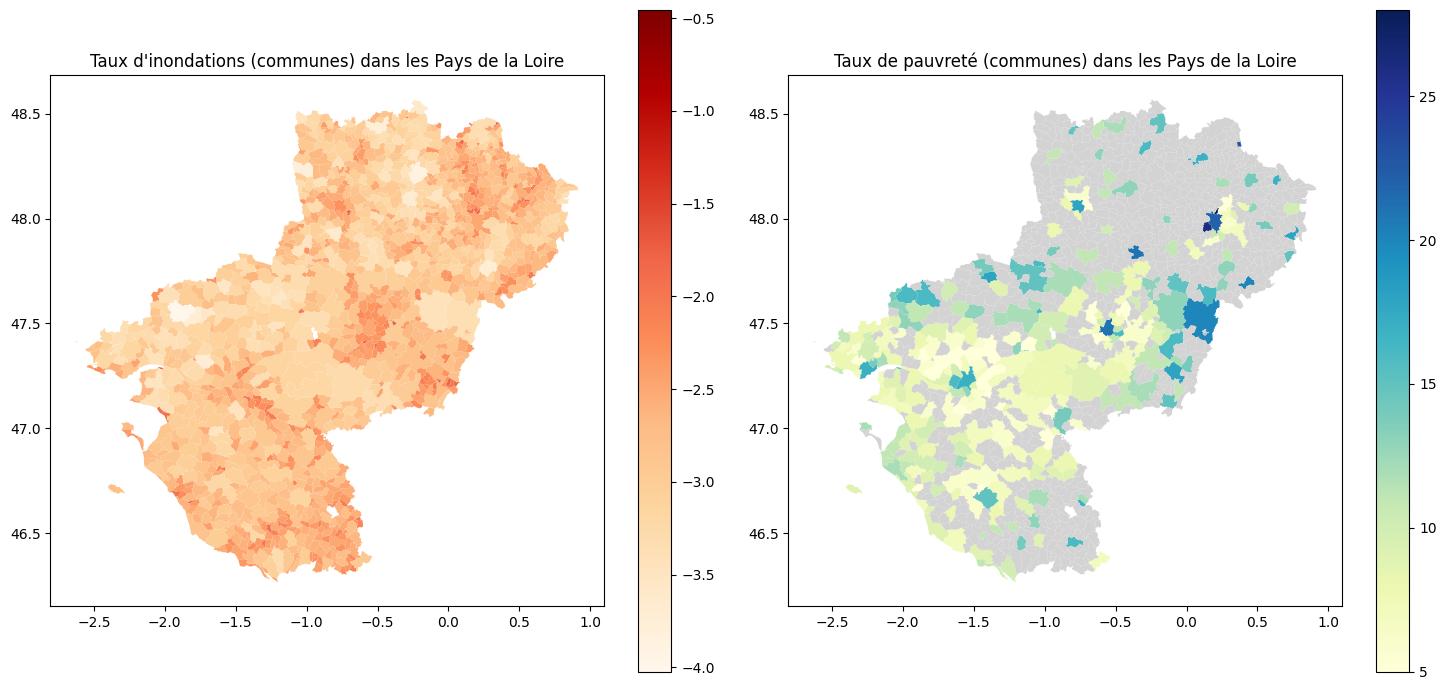

In [125]:
#### Nouveau problème : il faut pondérer les inondations par le nombre d'habitants (ou par la superficie au moins)

import numpy as np

# On pondère
gdf_pauvrete_pdl['Occurrences_ponderees_surf'] = gdf_pauvrete_pdl['Occurrences'] / gdf_pauvrete_pdl['surf_ha']
gdf_pauvrete_pdl['log_occurrences'] = gdf_pauvrete_pdl['Occurrences_ponderees_surf'].replace(0, np.nan).apply(np.log10)

# On visualise à nouveau
fig, axes = plt.subplots(1, 2, figsize=(15, 7))
gdf_pauvrete_pdl.plot(
    column='log_occurrences', 
    ax=axes[0], 
    legend=True, 
    cmap='OrRd'
)
axes[0].set_title("Taux d'inondations (communes) dans les Pays de la Loire")

gdf_pauvrete_pdl.plot(
    column='TP6021', 
    ax=axes[1], 
    legend=True, 
    cmap='YlGnBu',
    missing_kwds={
        "color": "lightgrey",  # couleur pour les NAs
        "label": "Données manquantes"  # optionnel : label dans la légende
    }
)
axes[1].set_title('Taux de pauvreté (communes) dans les Pays de la Loire')

plt.tight_layout()
plt.show()